In [107]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [108]:
path = 'data/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_from_file = (pd.read_csv(f, sep=',') for f in csv_files)
df_football = pd.concat(df_from_file, ignore_index = True)

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Date,Div,FTAG,FTHG,FTR,GBA,GBD,GBH,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,LBA,LBD,LBH,PSA,PSCA,PSCD,PSCH,PSD,PSH,Referee,SBA,SBD,SBH,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH
0,9.0,9.0,0.0,16.0,6.0,0.0,Malaga,3.2,3.25,2.25,3.0,3.30,2.30,3.25,3.40,2.25,38.0,21.0,-0.25,1.78,2.02,3.15,1.91,1.96,3.26,2.28,1.83,2.12,3.45,1.98,1.99,3.44,2.40,34.0,18/08/12,SP1,1.0,0.0,A,3.25,3.40,2.25,8.0,13.0,0.0,17.0,3.0,0.0,0.0,D,2.0,Celta,2.7,3.2,2.40,2.88,3.20,2.38,3.43,3.29,3.45,2.35,3.38,2.31,NaN,NaN,NaN,NaN,3.00,3.25,2.40,3.40,3.3,2.30,3.2,3.30,2.25
1,4.0,14.0,0.0,13.0,5.0,2.0,Espanol,3.8,3.30,2.00,3.6,3.25,2.05,4.10,3.30,2.00,38.0,20.0,-0.50,1.68,2.17,3.78,1.90,1.98,3.36,2.00,1.72,2.30,4.25,1.95,2.01,3.57,2.10,32.0,18/08/12,SP1,1.0,2.0,H,4.10,3.30,2.00,7.0,14.0,0.0,17.0,9.0,1.0,1.0,D,3.0,Mallorca,3.2,3.2,2.10,3.30,3.25,2.10,4.17,3.63,3.33,2.25,3.56,2.00,NaN,NaN,NaN,NaN,3.75,3.25,2.10,4.10,3.5,2.00,3.8,3.25,2.05
2,8.0,17.0,0.0,10.0,3.0,4.0,Getafe,5.5,3.75,1.62,5.0,3.60,1.70,5.50,3.75,1.60,38.0,23.0,-0.75,1.84,1.96,5.33,2.05,1.82,3.72,1.65,1.92,2.04,6.00,2.12,1.90,4.08,1.70,34.0,18/08/12,SP1,1.0,2.0,H,5.50,3.75,1.60,8.0,15.0,0.0,16.0,5.0,0.0,2.0,H,4.0,Sevilla,4.4,3.5,1.70,4.50,3.60,1.70,6.15,5.73,3.96,1.68,3.94,1.65,NaN,NaN,NaN,NaN,5.50,3.60,1.67,6.00,3.8,1.67,4.8,3.75,1.70
3,4.0,17.0,0.0,13.0,9.0,2.0,Betis,4.2,3.50,1.83,4.2,3.50,1.83,4.10,3.50,1.85,38.0,18.0,-0.75,1.92,1.88,4.18,1.76,2.12,3.54,1.85,2.00,2.00,4.50,1.81,2.18,3.83,1.91,34.0,19/08/12,SP1,5.0,3.0,A,4.10,3.50,1.85,11.0,12.0,0.0,17.0,8.0,3.0,0.0,A,2.0,Ath Bilbao,4.0,3.4,1.80,4.20,3.50,1.85,4.41,3.65,3.49,2.17,3.77,1.89,NaN,NaN,NaN,NaN,4.50,3.50,1.83,4.33,3.7,1.87,4.0,3.50,1.91
4,1.0,12.0,0.0,5.0,2.0,3.0,Sociedad,26.0,9.00,1.10,21.0,9.00,1.10,23.00,10.00,1.08,35.0,23.0,-2.75,3.36,1.30,24.64,1.93,1.93,9.77,1.09,3.65,1.33,34.00,1.99,1.98,13.00,1.12,23.0,19/08/12,SP1,1.0,5.0,H,23.00,10.00,1.08,9.0,9.0,0.0,18.0,10.0,1.0,4.0,H,2.0,Barcelona,14.0,7.0,1.12,17.00,8.00,1.11,31.00,35.36,13.96,1.09,12.00,1.10,NaN,NaN,NaN,NaN,29.00,9.00,1.10,31.00,12.0,1.10,29.0,11.00,1.07


In [109]:
df_football['Date'] = pd.to_datetime(df_football['Date'])
df_football['FTTG'] = df_football['FTHG'] + df_football['FTAG']

https://www.apuestafutbol.net/estrategia/apuestas-totales-con-handicap-asiatico.html

In [110]:
df_football.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D',
       'B365H', 'BSA', 'BSD', 'BSH', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH',
       'BbAHh', 'BbAv<2.5', 'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD',
       'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD',
       'BbMxH', 'BbOU', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'GBA', 'GBD',
       'GBH', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY',
       'HomeTeam', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH', 'PSA', 'PSCA',
       'PSCD', 'PSCH', 'PSD', 'PSH', 'Referee', 'SBA', 'SBD', 'SBH', 'SJA',
       'SJD', 'SJH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH', 'FTTG'],
      dtype='object')

# Limpiando los datos

In [111]:
df_football.describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,FTAG,FTHG,GBA,GBD,GBH,HC,HF,HR,HS,HST,HTAG,HTHG,HY,IWA,IWD,IWH,LBA,LBD,LBH,PSA,PSCA,PSCD,PSCH,PSD,PSH,SBA,SBD,SBH,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH,FTTG
count,11863.000000,11861.000000,11863.000000,11863.000000,11863.000000,11863.000000,13636.000000,13636.000000,13636.000000,4127.000000,4127.000000,4127.000000,13632.000000,13632.000000,13632.000000,13638.000000,13590.000000,13591.000000,13636.000000,13637.000000,13638.000000,13591.000000,13591.000000,13638.000000,13638.000000,13636.000000,13637.00000,13638.000000,13591.000000,13591.000000,13638.000000,13638.000000,13637.000000,13639.000000,13639.000000,4120.000000,4120.000000,4120.000000,11863.000000,11861.000000,11863.000000,11863.000000,11863.000000,13636.000000,13636.000000,11862.000000,13597.000000,13597.000000,13597.000000,13616.000000,13616.000000,13616.000000,11540.000000,11568.000000,11568.000000,11568.000000,11540.000000,11540.000000,2063.000000,2063.000000,2063.000000,6391.000000,6391.000000,6391.000000,13633.000000,13633.000000,13633.000000,13632.000000,13632.000000,13632.000000,13639.000000
mean,4.481834,13.886519,0.135379,11.229031,4.057827,2.164124,4.846709,3.963928,2.751831,4.478522,3.733998,2.542469,4.649639,3.897224,2.697385,42.777313,23.417292,-0.347178,1.953999,1.937068,4.778250,1.932849,1.932380,3.911916,2.726714,2.063149,2.03340,5.580003,1.995837,1.994102,4.252211,2.966289,36.732199,1.158809,1.540216,4.483400,3.735379,2.548949,5.757397,13.450215,0.100059,14.031021,5.101745,0.502933,0.684072,1.885264,4.316904,3.748695,2.590317,4.703662,3.858952,2.683074,5.191364,5.294952,4.229890,2.900566,4.183616,2.893685,4.570337,3.727910,2.576122,4.695530,3.825437,2.620016,5.160447,4.072567,2.828925,4.739087,3.756525,2.723911,2.699025
std,2.597806,4.479231,0.370304,4.554941,2.420239,1.372019,4.276676,1.380454,2.096573,3.368888,0.998581,1.639268,3.928506,1.292339,1.947996,5.566906,4.287111,0.836658,0.439769,0.304146,4.248944,0.140274,0.138897,1.327856,2.034664,0.506146,0.33612,6.072486,0.153506,0.151754,1.806156,2.533058,6.043914,1.153176,1.308250,3.337034,1.020388,1.661429,3.019911,4.395842,0.317562,5.225521,2.783302,0.717372,0.832551,1.319944,3.347600,1.014736,1.710205,4.290736,1.270260,1.958896,4.892646,5.271072,1.806885,2.401117,1.701409,2.384200,3.653762,1.102862,1.806678,3.992434,1.146448,1.820585,5.106541,1.546223,2.267847,4.208453,1.170096,1.975768,1.679642
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.080000,1.730000,1.020000,1.140000,1.730000,1.050000,1.090000,1.670000,1.030000,0.000000,1.000000,-3.500000,1.370000,1.090000,1.090000,1.450000,1.470000,1.750000,1.030000,1.410000,1.13000,1.100000,1.480000,1.500000,1.830000,1.050000,7.000000,0.000000,0.000000,1.120000,1.670000,1.050000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.100000,1.600000,1.030000,1.060000,1.830000,1.040000,1.090000,1.080000,2.200000,1.040000,2.200000,1.040000,1.111000,2.100000,1.040000,1.130000,1.800000,1.050000,1.080000,2.000000,1.030000,1.080000,1.020000,1.020000,0.000000
25%,3.000000,11.000000,0.000000,8.000000,2.000000,1.000000,2.500000,3.250000,1.670000,2.600000,3.250000,1.700000,2.550000,3.250000,1.700000,38.000000,20.000000,-0.750000,1.670000,1.720000,2.520000,1.830000,1.830000,3.240000,1.690000,1.750000,1.80000,2.650000,1.890000,1.880000,3.400000,1.750000,33.000000,0.000000,1.000000,2.600000,3.200000,1.700000,4.000000,10.000000,0.000000,10.000000,3.000000,0.000000,0.000000,1.000000,2.500000,3.200000,1.700000,2.500000,3.250000,1.670000,2.590000,2.580000,3.350000,1.700000,3.360000,1.710000,2.600000,3.200000,1.666000,2.600000,3.250000,1.670000,2.600000,3.300000,1.700000,2.600000,3.200000,1.700000,1.000000
50%,4.000000,14.000000,0.000000,11.000000,4.000000,2.000000,3.500000,3.500000,2.150000,3.400000,3.400000,2.100000,3.400000,3.400000,2.150000,43.000000,24.00

In [112]:
variables_to_remove = ['Bb1X2', 'BbOU', 'BbAH', 'BbAHh', 
                       'BbMxAHH', 'BbMxAHA', 'BbAvAHH', 'BbAvAHA']

df_football = df_football.drop(variables_to_remove, axis=1)
df_football.shape

(13650, 70)

In [113]:
null_data = df_football.isnull().mean()

Text(0.5,0,'percentage')

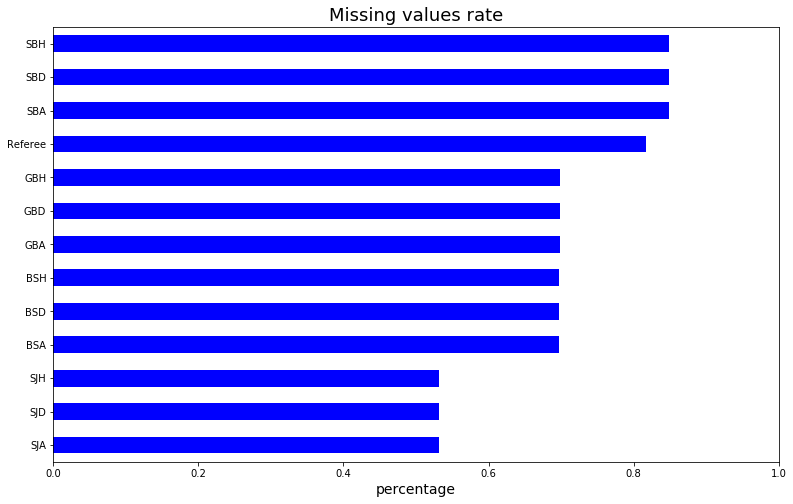

In [114]:
plt.figure(figsize = (13, 8))
null_data[null_data >= 0.3].sort_values().plot.barh(color = 'blue')
plt.xlim(xmax = 1)
plt.title("Missing values rate", fontsize = 18)
plt.xlabel("percentage", fontsize = 14)

In [115]:
features_no_null = null_data[null_data < 0.3].index
    
df_tmp = df_football[features_no_null].copy()
df_football = df_tmp.fillna(round(df_tmp.mean(), 2))

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,BbAv<2.5,BbAv>2.5,BbAvA,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxD,BbMxH,Date,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,LBA,LBD,LBH,PSA,PSCA,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH,FTTG
0,9.0,9.0,0.0,16.0,6.0,0.0,Malaga,3.2,3.25,2.25,3.25,3.40,2.25,1.78,2.02,3.15,3.26,2.28,1.83,2.12,3.45,3.44,2.40,2012-08-18,SP1,1.0,0.0,A,8.0,13.0,0.0,17.0,3.0,0.0,0.0,D,2.0,Celta,2.7,3.2,2.40,2.88,3.20,2.38,3.43,3.29,3.45,2.35,3.38,2.31,3.40,3.3,2.30,3.2,3.30,2.25,1.0
1,4.0,14.0,0.0,13.0,5.0,2.0,Espanol,3.8,3.30,2.00,4.10,3.30,2.00,1.68,2.17,3.78,3.36,2.00,1.72,2.30,4.25,3.57,2.10,2012-08-18,SP1,1.0,2.0,H,7.0,14.0,0.0,17.0,9.0,1.0,1.0,D,3.0,Mallorca,3.2,3.2,2.10,3.30,3.25,2.10,4.17,3.63,3.33,2.25,3.56,2.00,4.10,3.5,2.00,3.8,3.25,2.05,3.0
2,8.0,17.0,0.0,10.0,3.0,4.0,Getafe,5.5,3.75,1.62,5.50,3.75,1.60,1.84,1.96,5.33,3.72,1.65,1.92,2.04,6.00,4.08,1.70,2012-08-18,SP1,1.0,2.0,H,8.0,15.0,0.0,16.0,5.0,0.0,2.0,H,4.0,Sevilla,4.4,3.5,1.70,4.50,3.60,1.70,6.15,5.73,3.96,1.68,3.94,1.65,6.00,3.8,1.67,4.8,3.75,1.70,3.0
3,4.0,17.0,0.0,13.0,9.0,2.0,Betis,4.2,3.50,1.83,4.10,3.50,1.85,1.92,1.88,4.18,3.54,1.85,2.00,2.00,4.50,3.83,1.91,2012-08-19,SP1,5.0,3.0,A,11.0,12.0,0.0,17.0,8.0,3.0,0.0,A,2.0,Ath Bilbao,4.0,3.4,1.80,4.20,3.50,1.85,4.41,3.65,3.49,2.17,3.77,1.89,4.33,3.7,1.87,4.0,3.50,1.91,8.0
4,1.0,12.0,0.0,5.0,2.0,3.0,Sociedad,26.0,9.00,1.10,23.00,10.00,1.08,3.36,1.30,24.64,9.77,1.09,3.65,1.33,34.00,13.00,1.12,2012-08-19,SP1,1.0,5.0,H,9.0,9.0,0.0,18.0,10.0,1.0,4.0,H,2.0,Barcelona,14.0,7.0,1.12,17.00,8.00,1.11,31.00,35.36,13.96,1.09,12.00,1.10,31.00,12.0,1.10,29.0,11.00,1.07,6.0


# Conociendo los datos

```python
features_to_predict = ['FTTG', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
                       'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 
                       'AF', 'HY', 'AY', 'HR', 'AR']

features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
            'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA',
            'WHH', 'WHD', 'WHA', 
            
            'BbMxH', 'BbMxD', 'BbMxA', 'BbAvH', 'BbAvD', 'BbAvA',
            
            'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 
            
            'PSCH', 'PSCD', 'PSCA',
            
            'HomeTeam', 'AwayTeam']
```

In [116]:
features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
            'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA',
            'WHH', 'WHD', 'WHA', 
            
            'BbMxH', 'BbMxD', 'BbMxA', 'BbAvH', 'BbAvD', 'BbAvA',
            
            'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 
            
            'PSCH', 'PSCD', 'PSCA']

In [117]:
df_football[features].describe()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA,BbMxH,BbMxD,BbMxA,BbAvH,BbAvD,BbAvA,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,PSCH,PSCD,PSCA
count,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000,13650.000000
mean,2.751829,3.963924,4.846712,2.697388,3.897228,4.649640,2.590316,3.748700,4.316916,2.683066,3.858955,4.703653,2.893116,4.183057,5.191153,2.828926,4.072564,5.160447,2.723906,3.756530,4.739089,2.966292,4.252210,5.580003,2.726716,3.911914,4.778252,2.033397,1.937070,2.063146,1.953995,2.900480,4.229907,5.294197
std,2.095498,1.379746,4.274482,1.946711,1.291486,3.925915,1.706881,1.012764,3.341094,1.956455,1.268677,4.285388,2.192181,1.564381,4.498601,2.266434,1.545260,5.103360,1.974464,1.169325,4.205677,2.531944,1.805362,6.069816,2.033769,1.327272,4.247075,0.335960,0.304001,0.505887,0.439544,2.210412,1.663376,4.852426
min,1.020000,1.730000,1.080000,1.030000,1.670000,1.090000,1.030000,1.600000,1.100000,1.040000,1.830000,1.060000,1.040000,2.200000,1.090000,1.030000,2.000000,1.080000,1.020000,1.020000,1.080000,1.050000,1.830000,1.100000,1.030000,1.750000,1.090000,1.130000,1.090000,1.410000,1.370000,1.040000,2.200000,1.080000
25%,1.670000,3.250000,2.500000,1.700000,3.250000,2.550000,1.700000,3.200000,2.500000,1.670000,3.250000,2.500000,1.820000,3.400000,2.820000,1.700000,3.300000,2.600000,1.730000,3.200000,2.600000,1.750000,3.400000,2.650000,1.690000,3.240000,2.520000,1.800000,1.720000,1.750000,1.670000,1.810000,3.390000,2.780000
50%,2.150000,3.500000,3.500000,2.150000,3.400000,3.450000,2.100000,3.400000,3.300000,2.150000,3.400000,3.400000,2.400000,3.745000,4.105000,2.200000,3.500000,3.600000,2.200000,3.300000,3.400000,2.250000,3.630000,3.770000,2.150000,3.430000,3.470000,2.040000,1.950000,1.930000,1.840000,2.420000,3.760000,4.120000
75%,2.880000,4.000000,5.250000,2.800000,4.000000,5.000000,2.650000,3.800000,4.700000,2.800000,4.000000,5.000000,2.890000,4.180000,5.190000,2.900000,4.200000,5.400000,2.800000,3.800000,5.000000,3.000000,4.310000,5.750000,2.840000,3.980000,5.140000,2.270000,2.160000,2.210000,2.100000,2.900000,4.230000,5.290000
max,26.000000,17.000000,51.000000,34.000000,19.500000,51.000000,20.000000,16.000000,42.000000,29.000000,19.000000,61.000000,36.000000,29.000000,48.750000,36.000000,26.000000,67.000000,26.000000,17.000000,51.000000,39.170000,33.000000,92.570000,29.080000,18.640000,42.740000,5.400000,3.040000,7.550000,6.750000,37.630000,26.600000,60.500000


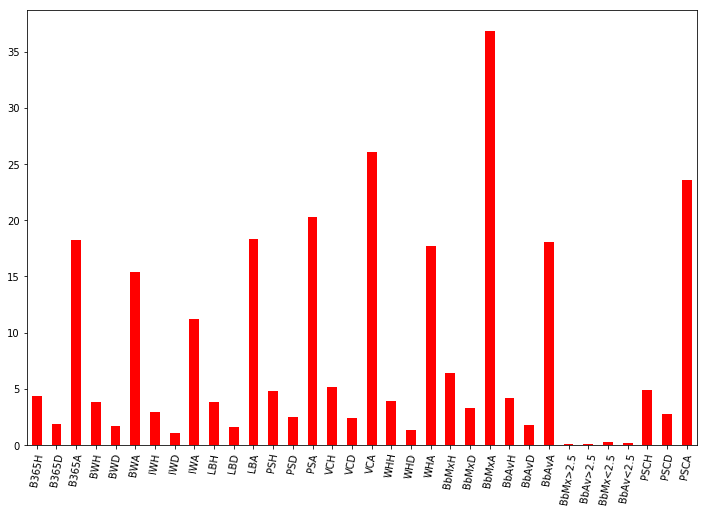

In [118]:
df_football[features].var().plot(kind='bar', color='r', rot=80)

Text(0,0.5,'Percentaje')

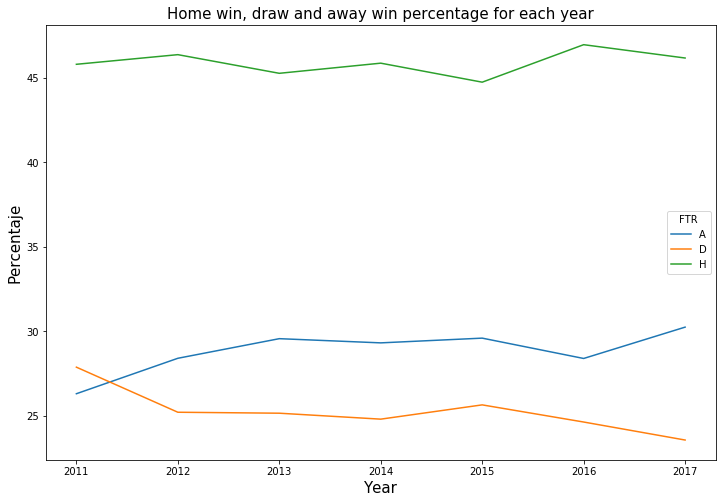

In [119]:
group = df_football.groupby([df_football.Date.dt.year, 'FTR']).size(). \
                    groupby(level = 0).transform(lambda x: (x/x.sum()) * 100)

group.unstack('FTR').plot()
plt.title('Home win, draw and away win percentage for each year', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Percentaje', fontsize=15)

Text(0,0.5,'Goals')

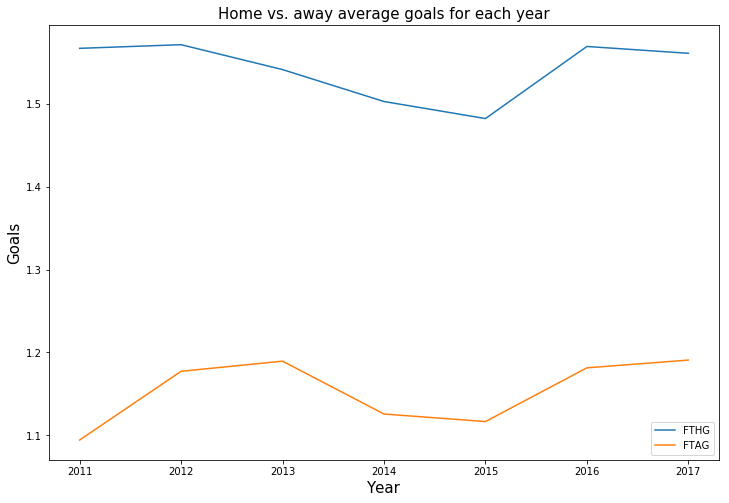

In [120]:
group = df_football.groupby([df_football.Date.dt.year])[['FTHG', 'FTAG']].mean()

group.plot()
plt.title('Home vs. away average goals for each year', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Goals', fontsize=15)

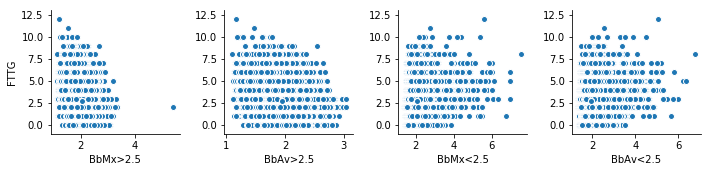

In [15]:
sns.pairplot(df_football, y_vars=['FTTG'], 
             x_vars=['BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5'])

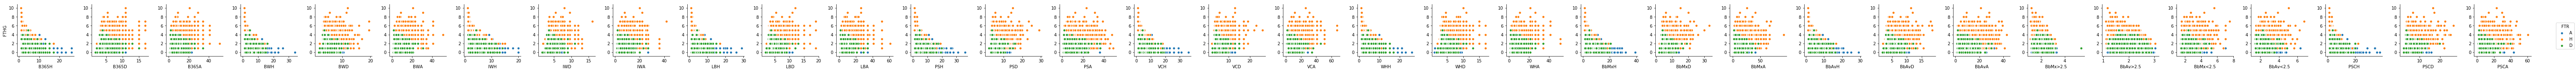

In [16]:
sns.pairplot(df_football, y_vars=['FTHG'], x_vars=features, hue="FTR")

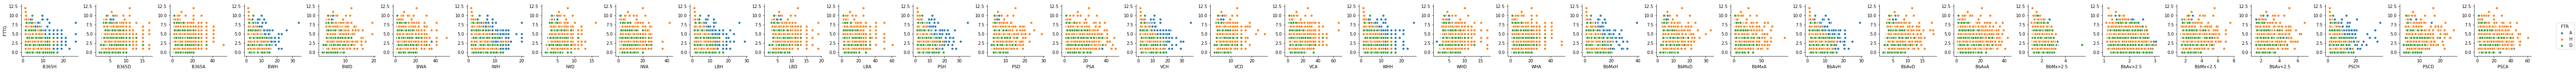

In [17]:
sns.pairplot(df_football, y_vars=['FTTG'], x_vars=features, hue="FTR")

# Dataframe final

In [122]:
features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
            'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA',
            'WHH', 'WHD', 'WHA', 
            
            'BbMxH', 'BbMxD', 'BbMxA', 'BbAvH', 'BbAvD', 'BbAvA', 
            
            'PSCH', 'PSCD', 'PSCA',
            
            'HomeTeam', 'AwayTeam']

feature_to_predict = ['FTHG']

df = df_football[features + feature_to_predict]
df.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA,BbMxH,BbMxD,BbMxA,BbAvH,BbAvD,BbAvA,PSCH,PSCD,PSCA,HomeTeam,AwayTeam,FTHG
0,2.25,3.25,3.2,2.25,3.40,3.25,2.40,3.2,2.7,2.38,3.20,2.88,2.31,3.38,3.43,2.30,3.3,3.40,2.25,3.30,3.2,2.40,3.44,3.45,2.28,3.26,3.15,2.35,3.45,3.29,Celta,Malaga,0.0
1,2.00,3.30,3.8,2.00,3.30,4.10,2.10,3.2,3.2,2.10,3.25,3.30,2.00,3.56,4.17,2.00,3.5,4.10,2.05,3.25,3.8,2.10,3.57,4.25,2.00,3.36,3.78,2.25,3.33,3.63,Mallorca,Espanol,2.0
2,1.62,3.75,5.5,1.60,3.75,5.50,1.70,3.5,4.4,1.70,3.60,4.50,1.65,3.94,6.15,1.67,3.8,6.00,1.70,3.75,4.8,1.70,4.08,6.00,1.65,3.72,5.33,1.68,3.96,5.73,Sevilla,Getafe,2.0
3,1.83,3.50,4.2,1.85,3.50,4.10,1.80,3.4,4.0,1.85,3.50,4.20,1.89,3.77,4.41,1.87,3.7,4.33,1.91,3.50,4.0,1.91,3.83,4.50,1.85,3.54,4.18,2.17,3.49,3.65,Ath Bilbao,Betis,3.0
4,1.10,9.00,26.0,1.08,10.00,23.00,1.12,7.0,14.0,1.11,8.00,17.00,1.10,12.00,31.00,1.10,12.0,31.00,1.07,11.00,29.0,1.12,13.00,34.00,1.09,9.77,24.64,1.09,13.96,35.36,Barcelona,Sociedad,5.0


In [123]:
homeTeam_dummies = pd.get_dummies(df_football.HomeTeam, prefix='HomeTeam')
awayTeam_dummies = pd.get_dummies(df_football.AwayTeam, prefix='AwayTeam')

df = pd.concat([df, homeTeam_dummies, awayTeam_dummies], axis = 1)

df = df.drop('HomeTeam', axis=1)
df = df.drop('AwayTeam', axis=1)

df.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA,BbMxH,BbMxD,BbMxA,BbAvH,BbAvD,BbAvA,PSCH,PSCD,PSCA,FTHG,HomeTeam_Academica,HomeTeam_Ajaccio,HomeTeam_Ajaccio GFCO,HomeTeam_Alaves,HomeTeam_Almeria,HomeTeam_Amiens,HomeTeam_Angers,HomeTeam_Arouca,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Atalanta,HomeTeam_Ath Bilbao,HomeTeam_Ath Madrid,HomeTeam_Augsburg,HomeTeam_Auxerre,HomeTeam_Aves,HomeTeam_Barcelona,HomeTeam_Bastia,HomeTeam_Bayern Munich,HomeTeam_Beira Mar,HomeTeam_Belenenses,HomeTeam_Benevento,HomeTeam_Benfica,HomeTeam_Betis,HomeTeam_Blackburn,HomeTeam_Boavista,HomeTeam_Bologna,HomeTeam_Bolton,HomeTeam_Bordeaux,HomeTeam_Bournemouth,HomeTeam_Braunschweig,HomeTeam_Brest,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Caen,HomeTeam_Cagliari,HomeTeam_Cardiff,HomeTeam_Carpi,HomeTeam_Catania,HomeTeam_Celta,HomeTeam_Cesena,HomeTeam_Chaves,HomeTeam_Chelsea,HomeTeam_Chievo,HomeTeam_Cordoba,HomeTeam_Crotone,HomeTeam_Crystal Palace,HomeTeam_Darmstadt,HomeTeam_Dijon,HomeTeam_Dortmund,HomeTeam_Eibar,HomeTeam_Ein Frankfurt,HomeTeam_Elche,HomeTeam_Empoli,HomeTeam_Espanol,HomeTeam_Estoril,HomeTeam_Everton,HomeTeam_Evian Thonon Gaillard,HomeTeam_FC Koln,HomeTeam_Feirense,HomeTeam_Feirense,HomeTeam_Fiorentina,HomeTeam_Fortuna Dusseldorf,HomeTeam_Freiburg,HomeTeam_Frosinone,HomeTeam_Fulham,HomeTeam_Genoa,HomeTeam_Getafe,HomeTeam_Gil Vicente,...,AwayTeam_Juventus,AwayTeam_Kaiserslautern,AwayTeam_La Coruna,AwayTeam_Las Palmas,AwayTeam_Lazio,AwayTeam_Lecce,AwayTeam_Leganes,AwayTeam_Leicester,AwayTeam_Leiria,AwayTeam_Lens,AwayTeam_Levante,AwayTeam_Leverkusen,AwayTeam_Lille,AwayTeam_Liverpool,AwayTeam_Livorno,AwayTeam_Lorient,AwayTeam_Lyon,AwayTeam_M'gladbach,AwayTeam_Mainz,AwayTeam_Malaga,AwayTeam_Mallorca,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Maritimo,AwayTeam_Marseille,AwayTeam_Metz,AwayTeam_Middlesbrough,AwayTeam_Milan,AwayTeam_Monaco,AwayTeam_Montpellier,AwayTeam_Moreirense,AwayTeam_Nacional,AwayTeam_Nancy,AwayTeam_Nantes,AwayTeam_Napoli,AwayTeam_Newcastle,AwayTeam_Nice,AwayTeam_Norwich,AwayTeam_Novara,AwayTeam_Nurnberg,AwayTeam_Olhanense,AwayTeam_Osasuna,AwayTeam_Pacos Ferreira,AwayTeam_Paderborn,AwayTeam_Palermo,AwayTeam_Paris SG,AwayTeam_Parma,AwayTeam_Penafiel,AwayTeam_Pescara,AwayTeam_Portimonense,AwayTeam_Porto,AwayTeam_QPR,AwayTeam_RB Leipzig,AwayTeam_Reading,AwayTeam_Real Madrid,AwayTeam_Reims,AwayTeam_Rennes,AwayTeam_Rio Ave,AwayTeam_Roma,AwayTeam_Sampdoria,AwayTeam_Santander,AwayTeam_Sassuolo,AwayTeam_Schalke 04,AwayTeam_Setubal,AwayTeam_Sevilla,AwayTeam_Siena,AwayTeam_Sochaux,AwayTeam_Sociedad,AwayTeam_Southampton,AwayTeam_Sp Braga,AwayTeam_Sp Gijon,AwayTeam_Sp Lisbon,AwayTeam_Spal,AwayTeam_St Etienne,AwayTeam_Stoke,AwayTeam_Strasbourg,AwayTeam_Stuttgart,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tondela,AwayTeam_Torino,AwayTeam_Tottenham,AwayTeam_Toulouse,AwayTeam_Troyes,AwayTeam_Udinese,AwayTeam_Uniao Madeira,AwayTeam_Valencia,AwayTeam_Valenciennes,AwayTeam_Valladolid,AwayTeam_Vallecano,AwayTeam_Verona,AwayTeam_Villarreal,AwayTeam_Watford,AwayTeam_Werder Bremen,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolfsburg,AwayTeam_Wolves,AwayTeam_Zaragoza
0,2.25,3.25,3.2,2.25,3.40,3.25,2.40,3.2,2.7,2.38,3.20,2.88,2.31,3.38,3.43,2.30,3.3,3.40,2.25,3.30,3.2,2.40,3.44,3.45,2.28,3.26,3.15,2.35,3.45,3.29,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2.00,3.30,3.8,2.00,3.30,4.10,2.10,3.2,3.2,2.10,3.25,3.30,2.00,3.56,4.17,2.00,3.5,4.10,2.05,3.25,3.8,2.10,3.57,4.25,2.00,3.36,3.78,2.25,3.33,3.63,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Análisis de componentes principales

In [124]:
from sklearn.decomposition import PCA

In [125]:
df_pca = df.copy()
del df_pca[feature_to_predict[0]]

pca = PCA()
pca.fit_transform(df_pca)

cum_variance = pca.explained_variance_ratio_[pca.explained_variance_ratio_.cumsum() < 0.975].cumsum()
n_components = cum_variance.size

print("Número de componentes: ", pca.n_components_)
print('\n')
print('Ratio de varianza de los 10 primeros componentes: \n', pca.explained_variance_ratio_[:10])
print('\n')
print('Ratio de varianza acumulada hasta explicar el 97.5%: \n', cum_variance)
print('\n')
print('Núm. componentes que explican el 97.5%: \n', n_components)

Número de componentes:  393


Ratio de varianza de los 10 primeros componentes: 
 [ 0.7983526   0.14376286  0.02139262  0.00498733  0.0042039   0.00374605
  0.00318229  0.00293135  0.0019451   0.00165058]


Ratio de varianza acumulada hasta explicar el 97.5%: 
 [ 0.7983526   0.94211545  0.96350808  0.96849541  0.97269931]


Núm. componentes que explican el 97.5%: 
 5


# Separación de datos de entrenamiento y prueba

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
df_X = df.copy()
df_y = df[feature_to_predict[0]].copy()
del df_X[feature_to_predict[0]]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.33, random_state = 42)

In [128]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (9145, 393)
X_test:  (4505, 393)
y_train: (9145,)
y_test:  (4505,)


In [129]:
# PCA Train
pca = PCA(n_components)
X_train_pca = pca.fit_transform(X_train)

# PCA Test
pca = PCA(n_components)
X_test_pca = pca.fit_transform(X_test)

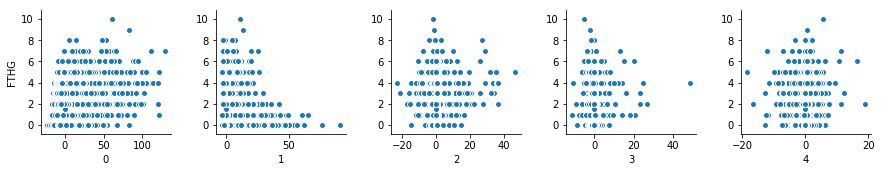

In [130]:
X_train_corr = pd.DataFrame(X_train_pca)
y_train_corr = pd.DataFrame(y_train).reset_index(drop=True)
X_train_corr = pd.concat([X_train_corr, y_train_corr], axis=1)

sns.pairplot(X_train_corr, y_vars=['FTHG'], x_vars=[0, 1, 2, 3, 4])

# Regresión lineal

In [131]:
from sklearn.linear_model import LinearRegression

### Regresión lineal básica

In [132]:
reg_LR = LinearRegression(normalize=True)
reg_LR_fit = reg_LR.fit(X_train_pca, y_train)
y_pred_LR = reg_LR.predict(X_test_pca)

In [133]:
print('Intercept: ', reg_LR.intercept_)
print('Coefficients: ', reg_LR.coef_)

Intercept:  1.54191142701
Coefficients:  [ 0.03347266 -0.0207401   0.01390949 -0.04542765  0.07761971]


In [134]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LR))
print('Variance score: %.2f' % r2_score(y_test, y_pred_LR))

Mean squared error: 1.43
Variance score: 0.16


### Regresión lineal con variables polinomiales

In [135]:
## Pipeline steps
polynomial_step = ('poly', PolynomialFeatures(2))
scaler_step = ('scaler', StandardScaler())
reg_step = ('reg', LinearRegression(normalize=True))

## Sort steps in a list
steps = [polynomial_step, scaler_step, reg_step]

## Pipeline creation
pipe = Pipeline(steps)
pipe.fit(X_train_pca, y_train)
y_pred_poly_reg = pipe.predict(X_test_pca)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_poly_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_poly_reg))

Mean squared error: 1.41
Variance score: 0.17


# Lasso

In [136]:
from sklearn.linear_model import Lasso

In [137]:
alphas = np.logspace(-4, -0.5, 20)
alphas

array([  1.00000000e-04,   1.52830673e-04,   2.33572147e-04,
         3.56969885e-04,   5.45559478e-04,   8.33782223e-04,
         1.27427499e-03,   1.94748304e-03,   2.97635144e-03,
         4.54877795e-03,   6.95192796e-03,   1.06246783e-02,
         1.62377674e-02,   2.48162892e-02,   3.79269019e-02,
         5.79639395e-02,   8.85866790e-02,   1.35387618e-01,
         2.06913808e-01,   3.16227766e-01])

In [138]:
lasso = Lasso(normalize=True)

tuned_parameters = {'alpha': alphas}
kfold = KFold(n_splits = 3)

gs_lasso = GridSearchCV(lasso, tuned_parameters, cv=kfold, n_jobs=-1)
gs_lasso.fit(X_train, y_train)

y_pred_lasso = gs_lasso.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lasso))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Mean squared error: 1.41
Variance score: 0.17


# Árboles de decisión

In [139]:
from sklearn.tree import DecisionTreeRegressor

### Árbol de decisión básico

In [140]:
reg_DT = DecisionTreeRegressor()
reg_DT.fit(X_train_pca, y_train)
y_pred_reg_DT = reg_DT.predict(X_test_pca)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Mean squared error: 3.03
Variance score: -0.78


In [141]:
reg_DT.tree_.max_depth

43

### Árbol de decisión con GridSearch

In [142]:
reg_DT_gscv = DecisionTreeRegressor()

params = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 15, 2),
          'min_samples_leaf': range(30, 40, 2)}

kfold = KFold(n_splits = 5)

gs_reg_DT = GridSearchCV(reg_DT_gscv, param_grid=params, cv=kfold, n_jobs=-1)
gs_reg_DT.fit(X_train_pca, y_train)

y_pred_reg_DT = gs_reg_DT.predict(X_test_pca)

print("Best params: ", gs_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Best params:  {'min_samples_split': 2, 'max_depth': 4, 'min_samples_leaf': 38}
Mean squared error: 1.45
Variance score: 0.15


In [143]:
reg_DT_gscv = DecisionTreeRegressor()

params = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 15, 2),
          'min_samples_leaf': range(30, 40, 2)}

kfold = KFold(n_splits = 3)

gs_reg_DT = GridSearchCV(reg_DT_gscv, param_grid=params, cv=kfold, n_jobs=-1)
gs_reg_DT.fit(X_train, y_train)

y_pred_reg_DT = gs_reg_DT.predict(X_test)

print("Best params: ", gs_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Best params:  {'min_samples_split': 2, 'max_depth': 3, 'min_samples_leaf': 32}
Mean squared error: 1.40
Variance score: 0.17


### Visualización de las variables más importantes

In [147]:
reg_DT = DecisionTreeRegressor(max_depth = gs_reg_DT.best_params_['max_depth'], 
                               min_samples_leaf = gs_reg_DT.best_params_['min_samples_leaf'], 
                               min_samples_split = gs_reg_DT.best_params_['min_samples_split'])
reg_DT.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

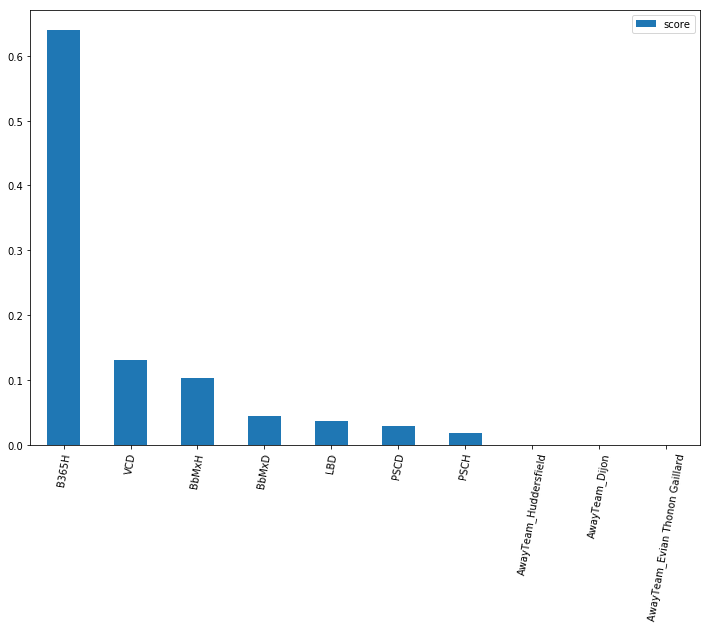

In [148]:
feat = pd.DataFrame(index=X_train.keys(), data=reg_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:10].plot(kind='bar', rot=80)

### Árbol de decisión con Polynomial features

In [42]:
# ## Pipeline steps
# polynomial_step = ('poly', PolynomialFeatures(2))
# scaler_step = ('scaler', StandardScaler())
# reg_DT_step = ('reg_DT', DecisionTreeRegressor())

# ## Sort steps in a list
# steps = [polynomial_step, scaler_step, reg_DT_step]

# ## Pipeline creation
# pipe = Pipeline(steps)

# tuned_parameters = {'reg_DT__max_depth': range(1, 10),
#                     'reg_DT__min_samples_split': range(2, 15, 2),
#                     'reg_DT__min_samples_leaf': range(30, 40, 2)}

# kfold = KFold(n_splits = 3)

# gs_poly_reg_DT = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
# gs_poly_reg_DT.fit(X_train_pca, y_train)

# y_pred_poly_reg_DT = gs_poly_reg_DT.predict(X_test_pca)

# print("Best params: ", gs_poly_reg_DT.best_params_)
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_poly_reg_DT))
# print('Variance score: %.2f' % r2_score(y_test, y_pred_poly_reg_DT))

### Visualizando el árbol

http://dataaspirant.com/2017/04/21/visualize-decision-tree-python-graphviz/

In [149]:
from sklearn import tree
import graphviz

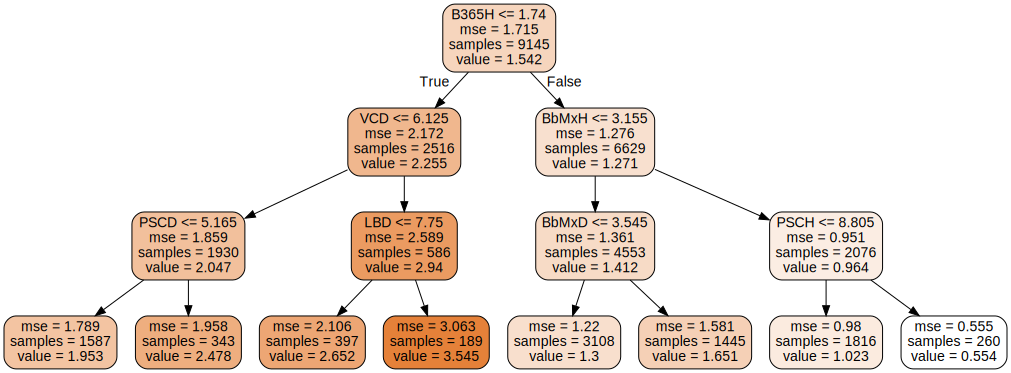

In [150]:
tree_graph = tree.export_graphviz(reg_DT, 
                                  out_file=None, 
                                  feature_names=X_train.columns,
                                  filled=True,
                                  rounded=True)
graphviz.Source(tree_graph)

# Bagging

http://scikit-learn.org/stable/modules/ensemble.html

In [45]:
from sklearn.ensemble import BaggingRegressor

In [46]:
bag_reg_DT = BaggingRegressor(DecisionTreeRegressor())

tuned_parameters = {'n_estimators': range(160, 210, 10)}
kfold = KFold(n_splits = 3)

gs_bag_reg_DT = GridSearchCV(bag_reg_DT, tuned_parameters, cv=kfold, n_jobs=-1)
gs_bag_reg_DT.fit(X_train, y_train)

y_pred_bag_reg_DT = gs_bag_reg_DT.predict(X_test)

print("Best params: ", gs_bag_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_bag_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_bag_reg_DT))

Best params:  {'n_estimators': 190}
Mean squared error: 1.42
Variance score: 0.15


# Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [151]:
rand_for_reg = RandomForestRegressor()

tuned_parameters = {'n_estimators': range(90, 130, 10),
                    'max_features': ['sqrt', 'auto'],
                    'max_depth': range(1, 10, 2)}
kfold = KFold(n_splits = 5)

gs_rand_for_reg = GridSearchCV(rand_for_reg, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_reg.fit(X_train, y_train)

y_pred_rand_for_reg = gs_rand_for_reg.predict(X_test)

print("Best params: ", gs_rand_for_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rand_for_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_rand_for_reg))

Best params:  {'max_features': 'auto', 'max_depth': 5, 'n_estimators': 100}
Mean squared error: 1.39
Variance score: 0.18


### Visualizando las variables más importantes

In [152]:
rand_for_reg = RandomForestRegressor(max_depth = gs_rand_for_reg.best_params_['max_depth'], 
                                     max_features = gs_rand_for_reg.best_params_['max_features'], 
                                     n_estimators = gs_rand_for_reg.best_params_['n_estimators'])
rand_for_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

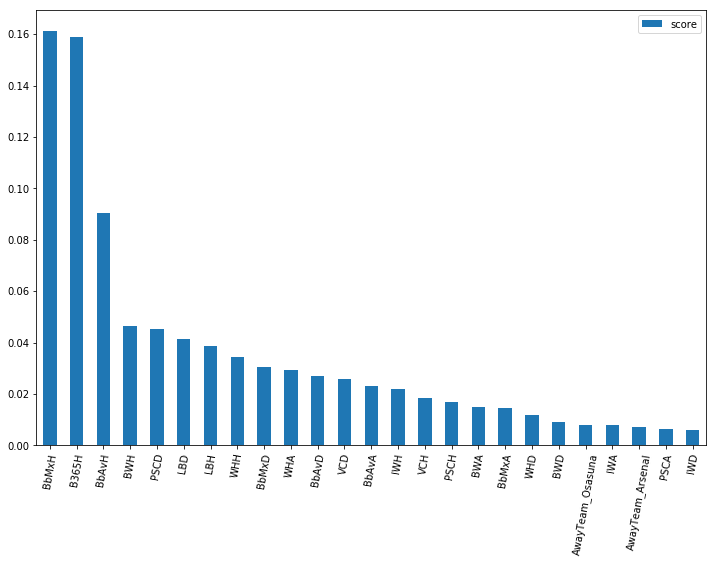

In [153]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_reg.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:25].plot(kind='bar', rot=80)

# Boosting

In [59]:
from sklearn.ensemble import AdaBoostRegressor

In [62]:
reg_DT = DecisionTreeRegressor()
ada_boost_reg = AdaBoostRegressor(reg_DT)

tuned_parameters = {'n_estimators': range(80, 100, 10),
                    'learning_rate': [1]}
kfold = KFold(n_splits = 3)

gs_ada_boost_reg = GridSearchCV(ada_boost_reg, tuned_parameters, cv=kfold, n_jobs=-1)
gs_ada_boost_reg.fit(X_train, y_train)

y_pred_ada_boost_reg = gs_ada_boost_reg.predict(X_test)

print("Best params: ", gs_ada_boost_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ada_boost_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_ada_boost_reg))

Best params:  {'learning_rate': 1, 'n_estimators': 90}
Mean squared error: 1.58
Variance score: 0.05


# XGBoost

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
gra_boost_reg = GradientBoostingRegressor()

tuned_parameters = {'n_estimators': range(50, 80, 10),
                    'learning_rate': [0.08, 0.1],
                    'max_depth': range(1, 10, 2),
                    'max_features': ['sqrt', None]}
kfold = KFold(n_splits = 3)

gs_gra_boost_reg = GridSearchCV(gra_boost_reg, tuned_parameters, cv=kfold, n_jobs=-1)
gs_gra_boost_reg.fit(X_train, y_train)

y_pred_gra_boost_reg = gs_gra_boost_reg.predict(X_test)

print("Best params: ", gs_gra_boost_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_gra_boost_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_gra_boost_reg))

Best params:  {'learning_rate': 0.08, 'max_features': 'sqrt', 'max_depth': 3, 'n_estimators': 60}
Mean squared error: 1.36
Variance score: 0.18


# Prediciendo 2018 mediante Random Forest

In [180]:
feature_to_predict = ['FTHG']

df_X_train = df.copy()
df_y_train = df_X_train[feature_to_predict[0]].copy()
del df_X_train[feature_to_predict[0]]

rand_for_reg = RandomForestRegressor(max_depth = 5, 
                                     max_features = 'auto', 
                                     n_estimators = 100)

final_rand_for_reg.fit(df_X_train, df_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [201]:
features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
            'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA',
            'WHH', 'WHD', 'WHA', 
            'BbMxH', 'BbMxD', 'BbMxA', 'BbAvH', 'BbAvD', 'BbAvA', 
            'PSCH', 'PSCD', 'PSCA',
            'HomeTeam', 'AwayTeam']

homeTeam_dummies = pd.get_dummies(df_football.HomeTeam, prefix='HomeTeam')
awayTeam_dummies = pd.get_dummies(df_football.AwayTeam, prefix='AwayTeam')


# Read CSV
path = 'test/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_from_file = (pd.read_csv(f, sep=',') for f in csv_files)
df_predict = pd.concat(df_from_file, ignore_index = True)

df_X_test = df_predict[features].copy()
df_X_test = df_X_test.fillna(round(df_X_test.mean(), 2))


# Dummy variables
homeTeam_dummies_test = pd.get_dummies(df_X_test.HomeTeam, prefix='HomeTeam')
homeTeam_dummies_test = homeTeam_dummies_test.T.reindex(homeTeam_dummies.columns).T.fillna(0)

awayTeam_dummies_test = pd.get_dummies(df_X_test.AwayTeam, prefix='AwayTeam')
awayTeam_dummies_test = awayTeam_dummies_test.T.reindex(awayTeam_dummies.columns).T.fillna(0)

df_X_test = pd.concat([df_X_test, homeTeam_dummies_test, awayTeam_dummies_test], axis = 1)

df_X_test = df_X_test.drop('HomeTeam', axis=1)
df_X_test = df_X_test.drop('AwayTeam', axis=1)


# Show
df_X_test.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA,BbMxH,BbMxD,BbMxA,BbAvH,BbAvD,BbAvA,PSCH,PSCD,PSCA,HomeTeam_Academica,HomeTeam_Ajaccio,HomeTeam_Ajaccio GFCO,HomeTeam_Alaves,HomeTeam_Almeria,HomeTeam_Amiens,HomeTeam_Angers,HomeTeam_Arouca,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Atalanta,HomeTeam_Ath Bilbao,HomeTeam_Ath Madrid,HomeTeam_Augsburg,HomeTeam_Auxerre,HomeTeam_Aves,HomeTeam_Barcelona,HomeTeam_Bastia,HomeTeam_Bayern Munich,HomeTeam_Beira Mar,HomeTeam_Belenenses,HomeTeam_Benevento,HomeTeam_Benfica,HomeTeam_Betis,HomeTeam_Blackburn,HomeTeam_Boavista,HomeTeam_Bologna,HomeTeam_Bolton,HomeTeam_Bordeaux,HomeTeam_Bournemouth,HomeTeam_Braunschweig,HomeTeam_Brest,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Caen,HomeTeam_Cagliari,HomeTeam_Cardiff,HomeTeam_Carpi,HomeTeam_Catania,HomeTeam_Celta,HomeTeam_Cesena,HomeTeam_Chaves,HomeTeam_Chelsea,HomeTeam_Chievo,HomeTeam_Cordoba,HomeTeam_Crotone,HomeTeam_Crystal Palace,HomeTeam_Darmstadt,HomeTeam_Dijon,HomeTeam_Dortmund,HomeTeam_Eibar,HomeTeam_Ein Frankfurt,HomeTeam_Elche,HomeTeam_Empoli,HomeTeam_Espanol,HomeTeam_Estoril,HomeTeam_Everton,HomeTeam_Evian Thonon Gaillard,HomeTeam_FC Koln,HomeTeam_Feirense,HomeTeam_Feirense,HomeTeam_Fiorentina,HomeTeam_Fortuna Dusseldorf,HomeTeam_Freiburg,HomeTeam_Frosinone,HomeTeam_Fulham,HomeTeam_Genoa,HomeTeam_Getafe,HomeTeam_Gil Vicente,HomeTeam_Girona,...,AwayTeam_Juventus,AwayTeam_Kaiserslautern,AwayTeam_La Coruna,AwayTeam_Las Palmas,AwayTeam_Lazio,AwayTeam_Lecce,AwayTeam_Leganes,AwayTeam_Leicester,AwayTeam_Leiria,AwayTeam_Lens,AwayTeam_Levante,AwayTeam_Leverkusen,AwayTeam_Lille,AwayTeam_Liverpool,AwayTeam_Livorno,AwayTeam_Lorient,AwayTeam_Lyon,AwayTeam_M'gladbach,AwayTeam_Mainz,AwayTeam_Malaga,AwayTeam_Mallorca,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Maritimo,AwayTeam_Marseille,AwayTeam_Metz,AwayTeam_Middlesbrough,AwayTeam_Milan,AwayTeam_Monaco,AwayTeam_Montpellier,AwayTeam_Moreirense,AwayTeam_Nacional,AwayTeam_Nancy,AwayTeam_Nantes,AwayTeam_Napoli,AwayTeam_Newcastle,AwayTeam_Nice,AwayTeam_Norwich,AwayTeam_Novara,AwayTeam_Nurnberg,AwayTeam_Olhanense,AwayTeam_Osasuna,AwayTeam_Pacos Ferreira,AwayTeam_Paderborn,AwayTeam_Palermo,AwayTeam_Paris SG,AwayTeam_Parma,AwayTeam_Penafiel,AwayTeam_Pescara,AwayTeam_Portimonense,AwayTeam_Porto,AwayTeam_QPR,AwayTeam_RB Leipzig,AwayTeam_Reading,AwayTeam_Real Madrid,AwayTeam_Reims,AwayTeam_Rennes,AwayTeam_Rio Ave,AwayTeam_Roma,AwayTeam_Sampdoria,AwayTeam_Santander,AwayTeam_Sassuolo,AwayTeam_Schalke 04,AwayTeam_Setubal,AwayTeam_Sevilla,AwayTeam_Siena,AwayTeam_Sochaux,AwayTeam_Sociedad,AwayTeam_Southampton,AwayTeam_Sp Braga,AwayTeam_Sp Gijon,AwayTeam_Sp Lisbon,AwayTeam_Spal,AwayTeam_St Etienne,AwayTeam_Stoke,AwayTeam_Strasbourg,AwayTeam_Stuttgart,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tondela,AwayTeam_Torino,AwayTeam_Tottenham,AwayTeam_Toulouse,AwayTeam_Troyes,AwayTeam_Udinese,AwayTeam_Uniao Madeira,AwayTeam_Valencia,AwayTeam_Valenciennes,AwayTeam_Valladolid,AwayTeam_Vallecano,AwayTeam_Verona,AwayTeam_Villarreal,AwayTeam_Watford,AwayTeam_Werder Bremen,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolfsburg,AwayTeam_Wolves,AwayTeam_Zaragoza
0,3.0,3.20,2.50,3.10,3.10,2.45,2.8,3.2,2.6,2.90,3.25,2.45,3.12,3.28,2.54,3.13,3.20,2.50,2.9,3.1,2.50,3.17,3.28,2.60,3.02,3.17,2.48,3.40,3.19,2.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [204]:
y_final_prediction = final_rand_for_reg.predict(df_X_test)

y_final_prediction = pd.DataFrame(y_final_prediction, columns=['FTHG_PRED']).round()

df_y_test = df_predict[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG']].copy()

df_final_prediction = pd.concat([df_y_test, y_final_prediction], axis=1)
df_final_prediction

,Div,Date,HomeTeam,AwayTeam,FTHG,FTHG_PRED
0,I1,05/01/18,Chievo,Udinese,1.0,1.0
1,I1,05/01/18,Fiorentina,Inter,1.0,1.0
2,I1,06/01/18,Benevento,Sampdoria,3.0,1.0
3,I1,06/01/18,Cagliari,Juventus,0.0,1.0
4,I1,06/01/18,Genoa,Sassuolo,1.0,1.0
5,I1,06/01/18,Milan,Crotone,1.0,2.0
6,I1,06/01/18,Napoli,Verona,2.0,3.0
7,I1,06/01/18,Roma,Atalanta,1.0,2.0
8,I1,06/01/18,Spal,Lazio,2.0,1.0
9,I1,06/01/18,Torino,Bologna,3.0,1.0
